## An inferential problem: The Gender Wage Gap

In [6]:
library('dplyr') # filter dataset

In [7]:
load("../../data/wage2015_subsample_inference.Rdata")
dim(data)

[1] 5150   20

In [8]:
head(data)

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
10,9.615385,2.263364,1,0,0,0,1,0,0,0,0,1,7,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0,0,0,0,1,0,0,0,0,1,31,9.61,29.791,92.3521,3050,10,5070,9
15,11.057692,2.403126,0,0,1,0,0,0,0,0,0,1,18,3.24,5.832,10.4976,6260,19,770,4
18,13.942308,2.634928,1,0,0,0,0,1,0,0,0,1,25,6.25,15.625,39.0625,420,1,6990,12
19,28.846154,3.361977,1,0,0,0,1,0,0,0,0,1,22,4.84,10.648,23.4256,2015,6,9470,22
30,11.730769,2.462215,1,0,0,0,1,0,0,0,0,1,1,0.01,0.001,0.0001,1650,5,7460,14


In [9]:
# Focus on the subset of college-educated workers

data <- data %>% filter(scl==1 | clg ==1)
dim(data)

attach(data) 

[1] 3068   20

In [10]:
# cheking focus ollege-educated workers

unique(data$shs)
unique(data$ad)

[1] 0

[1] 0

In [11]:
#install.packages('ggplot2')

library(ggplot2)

In [12]:
data <- data %>% mutate(gender = ifelse(sex == 1 , "Women", "Men"))

### 1.0 Main statistics 

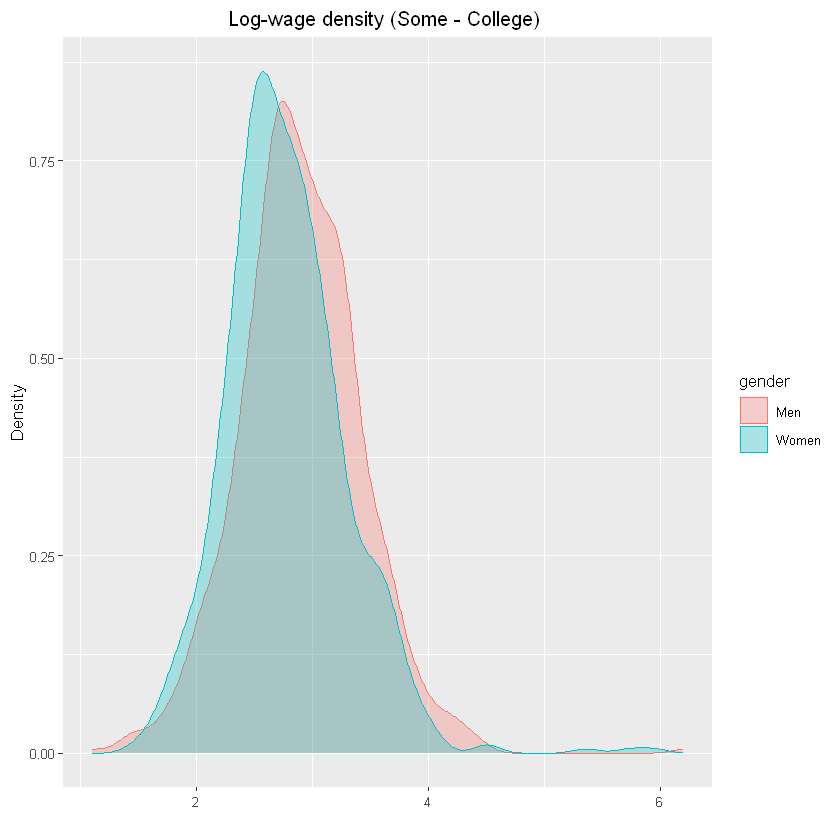

In [13]:
data %>% filter(scl == 1) %>%
ggplot(aes(x=lwage, fill = gender , colour=gender)) +
  geom_density(alpha=0.3) +
ggtitle("Log-wage density (Some - College) ") + theme(text=element_text(size =10), plot.title = element_text(hjust = 0.5)) +
labs(x = "", 
     y = "Density")

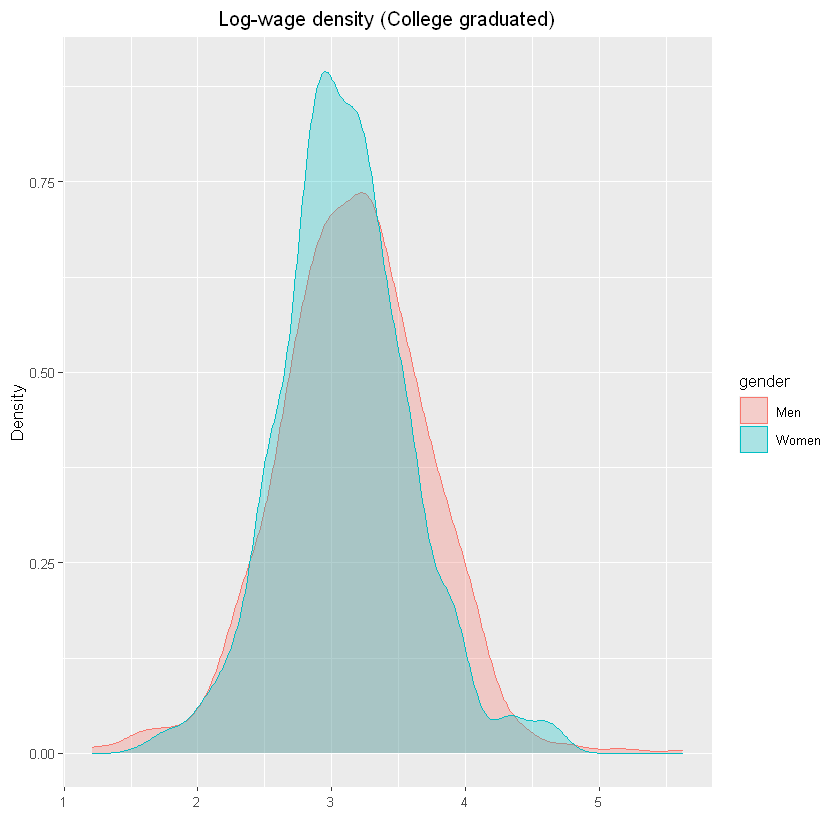

In [14]:
data %>% filter(clg == 1) %>%
ggplot(aes(x=lwage, fill = gender , colour=gender)) +
  geom_density(alpha=0.3) +
ggtitle("Log-wage density (College graduated)") + theme(text=element_text(size =10), plot.title = element_text(hjust = 0.5)) +
labs(x = "", 
     y = "Density")

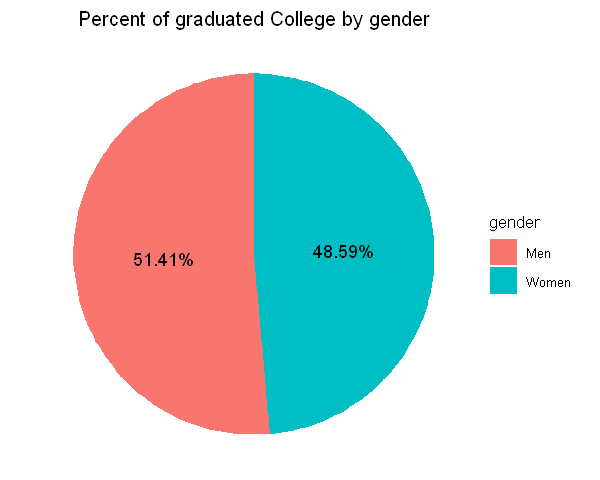

In [15]:
options(repr.plot.width = 5, repr.plot.height =4) 

data %>% mutate(total = sum(clg)) %>%
        group_by(gender) %>% 
                    summarise(clg_total = sum(clg), total = mean(total)) %>% 
        mutate(var1 = (clg_total/total)*100 )  %>%
        ggplot(aes(x="", y=var1, fill=gender)) +
          geom_bar(stat="identity", width=1) +
          coord_polar("y", start=0) +
          theme_void() +
        geom_text(aes(label = paste0(round(var1,2), "%")), position = position_stack(vjust=0.5)) + 
            labs(title = "Percent of graduated College by gender") + theme(text=element_text(size =10), plot.title = element_text(hjust = 0.5))

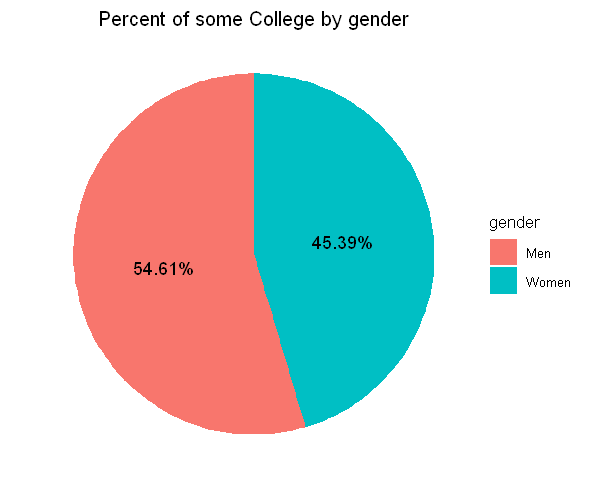

In [16]:
options(repr.plot.width = 5, repr.plot.height =4) 

data %>% mutate(total = sum(scl)) %>%
        group_by(gender) %>% 
                    summarise(clg_total = sum(scl), total = mean(total)) %>% 
        mutate(var1 = (clg_total/total)*100 )  %>%
        ggplot(aes(x="", y=var1, fill=gender)) +
          geom_bar(stat="identity", width=1) +
          coord_polar("y", start=0) +
          theme_void() +
        geom_text(aes(label = paste0(round(var1,2), "%")), position = position_stack(vjust=0.5)) + 
            labs(title = "Percent of some College by gender") + theme(text=element_text(size =10), plot.title = element_text(hjust = 0.5))

In [17]:
#install.packages('sandwich')

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

In [18]:
library(sandwich)

nocontrol.fit <- lm(lwage ~ sex)
nocontrol.est <- summary(nocontrol.fit)$coef["sex",1]
HCV.coefs <- vcovHC(nocontrol.fit, type = 'HC');
nocontrol.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors

# print unconditional effect of gender and the corresponding standard error
cat ("The estimated gender coefficient is",nocontrol.est," and the corresponding robust standard error is",nocontrol.se) 


The estimated gender coefficient is -0.08150856  and the corresponding robust standard error is 0.01957965

Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

In [19]:
# Ols regression with controls

flex <- lwage ~ sex + (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)

#   Note that ()*() operation in formula objects in R creates a formula of the sort:
#  (exp1+exp2+exp3+exp4)+ (shs+hsg+scl+clg+occ2+ind2+mw+so+we) +  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)
#  This is not intuitive at all, but that's what it does.

control.fit <- lm(flex, data=data)
control.est <- summary(control.fit)$coef[2,1]


HCV.coefs <- vcovHC(control.fit, type = 'HC');
control.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors

cat ("The estimated gender coefficient is",control.est," and the corresponding robust standard error is",control.se) 

The estimated gender coefficient is -0.05306234  and the corresponding robust standard error is 0.01835285

The estimated regression coefficient $\beta_1\approx-0.0530$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $8.1$\% for women decreases to about $5.3$\% after controlling for worker characteristics.  


In [20]:
# Partialling-Out using ols

# models
flex.y <- lwage ~  (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we) # model for Y
flex.d <- sex ~ (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we) # model for D

# partialling-out the linear effect of W from Y
t.Y <- lm(flex.y, data=data)$res
# partialling-out the linear effect of W from D
t.D <- lm(flex.d, data=data)$res

# regression of Y on D after partialling-out the effect of W
partial.fit <- lm(t.Y~t.D)
partial.est <- summary(partial.fit)$coef[2,1]

cat("Coefficient for D via partialling-out", partial.est)

# standard error
HCV.coefs <- vcovHC(partial.fit, type = 'HC')
partial.se <- sqrt(diag(HCV.coefs))[2]

# confidence interval
confint(partial.fit)[2,]

Coefficient for D via partialling-out -0.05306234

2.5 %      97.5 % 
-0.08957070 -0.01655398

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

In the following, we illustrate the partialling-out approach using lasso instead of ols.

In [29]:
#install.packages('xtable')

library(lmtest)
library(xtable)

In [30]:
table<- matrix(0, 3, 4)
table[1,1]<- nocontrol.est  
table[1,2]<- nocontrol.se   
table[2,1]<- control.est
table[2,2]<- control.se    
table[3,1]<- partial.est  
table[3,2]<- partial.se 
table[1,3]<- coefci(nocontrol.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,1] 
table[1,4]<- coefci(nocontrol.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,2] 
table[2,3]<- coefci(control.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,1] 
table[2,4]<- coefci(control.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,2] 
table[3,3]<- coefci(partial.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,1] 
table[3,4]<- coefci(partial.fit, df = Inf, vcov. = vcovHC, type = "HC")[2,2] 

colnames(table)<- c("Estimate","se","lower_bound","upper_bound")
rownames(table)<- c("OLS", "OLS with control", "Partialling out approach")
tab<- xtable(table)
tab

,Estimate,se,lower_bound,upper_bound
,<dbl>,<dbl>,<dbl>,<dbl>
OLS,-0.08150856,0.01957965,-0.11988396,-0.04313315
OLS with control,-0.05306234,0.01835285,-0.08903326,-0.01709142
Partialling out approach,-0.05306234,0.01835285,-0.08903326,-0.01709142


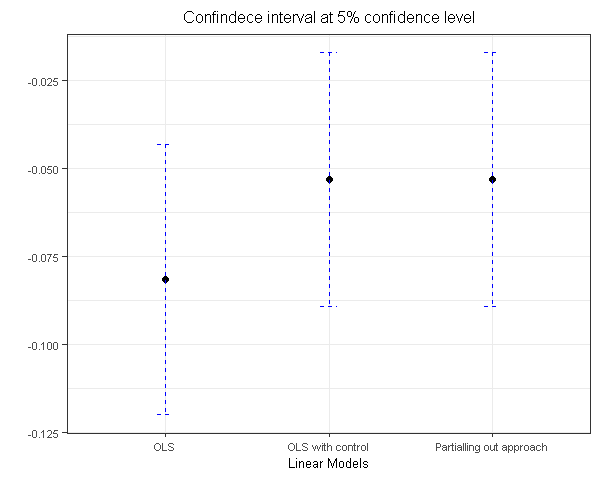

In [31]:
options(repr.plot.width = 5, repr.plot.height =4)  # plot size 

ggplot(tab, aes(x=rownames(tab), y=Estimate)) +
    geom_point(size=1.5) + 
    geom_errorbar(aes(ymin=lower_bound, ymax=upper_bound) , width = 0.1,color="blue", linetype="dashed") + 
  labs(x="Linear Models", y="") + ggtitle("Confindece interval at 5% confidence level") +
  theme_bw()  + theme(text=element_text(size =8), plot.title = element_text(hjust = 0.5))

# Graph: Experience profile and log-wage

The task is to replicate the Figure 11.10 from Lemieux (2006) considering that "you will have only two plotted lines for this college-educated workers". It means we have to plot using the subset of the original data.

A first way is to collapse the data to plot the mean of log-wages for each year of experience. To do so, we first estimate the logwage by a quafratic and quartic expressions, and then we clean the data to plot.

In [32]:
data <- data %>% filter(clg == 1)

In [33]:
quartic   <- lwage ~  exp1+exp2+exp3+exp4
quadratic <- lwage ~  exp1+exp2

# quartic
quartic_pred <- predict(lm(quartic, data=data))

# quadratic
quadratic_pred <- predict(lm(quadratic, data=data))

# adding predictions
z_clg <- data %>% mutate(lwage_quartic = quartic_pred)
z_clg <- z_clg %>% mutate(lwage_quadratic = quadratic_pred)



In [34]:
# cleaning data to plot
graph_2 <- z_clg %>% group_by(exp1, clg) %>% 
  summarise_at(vars(lwage, lwage_quartic, lwage_quadratic), mean)
names(graph_2)

[1] "exp1"            "clg"             "lwage"           "lwage_quartic"  
[5] "lwage_quadratic"

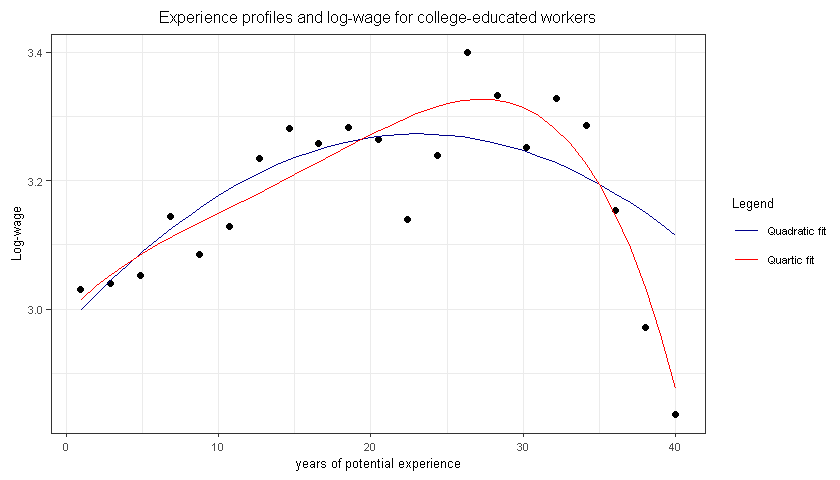

In [35]:
options(repr.plot.width = 7, repr.plot.height =4) 


ggplot(NULL,aes(exp1,lwage)) +
stat_summary_bin(data=z_clg, fun='mean', bins=20, color='black', size=1.5, geom='point') +
geom_line(data=z_clg, aes(x=exp1, y=lwage_quadratic, colour="darkblue")) + 
geom_line(data=z_clg, aes(x=exp1, y=lwage_quartic, colour="red")) +
labs(x = "years of potential experience", 
     y = "Log-wage", 
     title = "Experience profiles and log-wage for college-educated workers") +
theme(legend.key.height = unit(1, 'cm')) +
scale_color_identity(name = "Legend", labels = c("Quadratic fit", "Quartic fit"),
                     guide = "legend")+
  theme_bw() + theme(text=element_text(size =8), plot.title = element_text(hjust = 0.5))

It is clear that the relation between experiencie and log-wage fits better to the quartic prediction.